# Text Generation

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

### Helping Functions

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

In [4]:
def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

## Step 1 : Get the Corpus

In [5]:
path = tf.keras.utils.get_file('songdata.csv', 
                               'https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8')
print (path)

C:\Users\Amir\.keras\datasets\songdata.csv


In [6]:
# Read the dataset from csv - this time with 250 songs 
dataset = pd.read_csv(path, dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')

## Step 2 : Tokenize the Corpus

In [7]:
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

In [8]:
# There should be a lot more words now
print(total_words)

2000


## Step 3 : Create n-Gram

In [9]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

## Step 4 : Pad sequences

In [10]:
# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

## Step 5 : X and y - Values

In [11]:
# Split sequences between the "input" sequence and "output" predicted word
X = sequences[:,:-1]
y_label = sequences[:,-1]
# One-hot encode the labels
y = tf.keras.utils.to_categorical(y_label, num_classes=total_words)

## Step 6 : Create Model

In [14]:
EPOCHS = 100
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=EPOCHS, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 18s 12ms/step - loss: 5.9802 - accuracy: 0.0463
Epoch 2/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.6712 - accuracy: 0.0507
Epoch 3/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.4987 - accuracy: 0.0621
Epoch 4/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.3391 - accuracy: 0.0853
Epoch 5/100
1480/1480 [==============================] - 17s 11ms/step - loss: 5.2055 - accuracy: 0.1012
Epoch 6/100
1480/1480 [==============================] - 16s 11ms/step - loss: 5.0699 - accuracy: 0.1204
Epoch 7/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.9368 - accuracy: 0.1350
Epoch 8/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.8126 - accuracy: 0.1482
Epoch 9/100
1480/1480 [==============================] - 16s 11ms/step - loss: 4.6809 - accuracy: 0.1614
Epoch 10/100
1480/1480 [==============================]

In [15]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

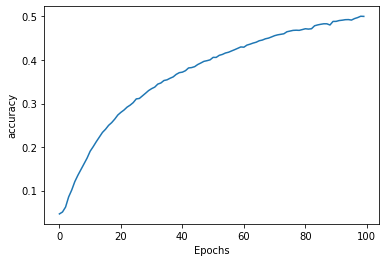

In [16]:
plot_graphs(history, 'accuracy')

This time around, we should be able to get a more interesting output with less repetition

## Step 7: Generate Text

In [17]:
seed_text = "im feeling chills"
next_words = 100

In [18]:
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills a little longer yeah you do alright pick a little bit that sun grow doublecross inside cutie to taught christmas of hoy more tomorrow other colors changing sigh single line while lala im gonna dance or somebody old goin phone on letters up for each other side hour chance in space back joy single side with forever live sister hang nile woke excite single dum shoes phone heh speaking gold ancient high upon gold result of hesitation of hesitation of fights phone shove her part phone other dark deep dark shove waterloo ground seeing can use forever shine to her


### Extra Step : Add Randomization

Varying the Possible Outputs

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output? 

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [19]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100

In [20]:
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

7


In [21]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100

In [22]:
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills a man in the rough its so my girl goes worse right promises phone track the children devotion bring misunderstood ground weave shine yeah up be my day with us to show he eternal ways get gone too far together light phone im a way from sunny time single other side heavens wish girls single tiger fault difference walked high what fuckin bay sorrow track emotion regrets diddle diggin diddle nearly kisses hardly plan march chasing phone heh beats ballerina phone on that night if it yes he got so nothin nothin nothin to me it doesnt share of love
